In [75]:
import pandas as pd
import numpy as np
from itertools import combinations

df = pd.read_csv('data/modules/marks_summary_modules.csv')

latest_year = '2023/24'
valid_modules = df[df['year'] == latest_year]['code'].unique()
df = df[df['code'].isin(valid_modules)]

def aggregate_module(group):
    total_takers = group['marks'].sum()
    
  
    if total_takers == 0:
        return pd.Series({
            'Mean': np.nan,
            'q10': np.nan,
            'Median': np.nan,
            'q90': np.nan,
            'Pooled_SD': np.nan,
            'Average Takers Per Year': 0,
            'Years Counted': 0
        })

    
    mean = np.average(group['mean'], weights=group['marks'])
    
    
    q10 = group['q10'].mean()
    median = group['median'].mean()
    q90 = group['q90'].mean()
    
    
    numer = ((group['marks'] - 1) * group['sd'] ** 2).sum()
    denom = group['marks'].sum() - group.shape[0]
    pooled_sd = np.sqrt(numer / denom) if denom > 0 else np.nan

    return pd.Series({
        'mean': mean,
        'q10': q10,
        'Median': median,
        'q90': q90,
        'Pooled_SD': pooled_sd,
        'Total Takers': total_takers/group.shape[0],
        'Years Counted': group.shape[0]
    })


summary_df = df.groupby('code').apply(aggregate_module).reset_index()
module_facts_df = pd.read_csv("data/modules/modul_key_facts_updated.csv")
summary_df = summary_df.merge(module_facts_df[['code', 'units']], on='code', how='left')


outside_options = pd.read_csv('data/modules/outside_options.csv')


outside_options_marks = outside_options.merge(
    summary_df,
    left_on='code',
    right_on='code',
    how='left'
)
def parse_list_string(s):
    if pd.isna(s) or s.strip() == '[]':
        return []
    return [item.strip().strip("'\"") for item in s.strip('[]').split(',')]

outside_options_marks.drop(columns=['course', 'total_students', 'avg_class_size', 'capped'], inplace=True)

outside_options_marks.sort_values(by='mean', ascending=False, inplace=True)
outside_options_marks['parsed_prereqs'] = outside_options_marks['prerequisites'].apply(parse_list_string)
outside_options_marks['parsed_exclusions'] = outside_options_marks['mutually_exclusive_courses'].apply(parse_list_string)
print("Outside Option List")
outside_options_marks


Outside Option List


code                                  prerequisites  \
67    EC336                    ['ST102', 'MA100', 'ST109']   
69    EC338                             ['EC201', 'EC202']   
231   LN200                                      ['LN100']   
252   MA209  ['MA203', 'MA212', 'MA103', 'MA102', 'MA100']   
38   DS105A                                             []   
..      ...                                            ...   
318   PH241                                             []   
330   SP232                                             []   
331   SP314                                             []   
339   SP374                                             []   
346   ST110                                      ['ST109']   

    mutually_exclusive_courses  units_x  \
67                          []      0.5   
69                          []      0.5   
231                         []      1.0   
252                         []      0.5   
38                  ['DS105W']      0.5   
..                         ...      ...   
318                         []      0.5   
330                         []      1.0   
331                         []      0.5   
339                         []      0.5   
346            ['ST107,ST102']      0.5   

                                  department       mean     q10  Median  \
67                                 Economics  81.200000  71.500  82.500   
69                                 Economics  75.300000  51.200  80.000   
231                          Language Centre  74.455556  72.525  74.625   
252                              Mathematics  74.407551  55.860  75.100   
38                    Data Science Institute  73.800000  62.800  76.000   
..                                       ...        ...     ...     ...   
318  Philosophy, Logic and Scientific Method        NaN     NaN     NaN   
330                            Social Policy        NaN     NaN     NaN   
331                            Social Policy        NaN     NaN     NaN   
339                            Social Policy        NaN     NaN     NaN   
346                               Statistics        NaN     NaN     NaN   

        q90  Pooled_SD  Total Takers  Years Counted  units_y  \
67   89.500   8.300000          6.00            1.0      0.5   
69   91.000  18.600000         43.00            1.0      0.5   
231  75.925   2.844996          2.25            4.0      1.0   
252  91.980  14.521311         87.40            5.0      0.5   
38   84.000   9.700000         49.00            1.0      0.5   
..      ...        ...           ...            ...      ...   
318     NaN        NaN           NaN            NaN      NaN   
330     NaN        NaN           NaN            NaN      NaN   
331     NaN        NaN           NaN            NaN      NaN   
339     NaN        NaN           NaN            NaN      NaN   
346     NaN        NaN           NaN            NaN      NaN   

                          parsed_prereqs parsed_exclusions  
67                 [ST102, MA100, ST109]                []  
69                        [EC201, EC202]                []  
231                              [LN100]                []  
252  [MA203, MA212, MA103, MA102, MA100]                []  
38                                    []          [DS105W]  
..                                   ...               ...  
318                                   []                []  
330                                   []                []  
331                                   []                []  
339                                   []                []  
346                              [ST109]    [ST107, ST102]  

[373 rows x 15 columns]

In [76]:
compulsory_mods_lse_df =pd.read_csv('data/degrees/programme_data_NDC.csv')
compulsory_mods_lse_df['modules_y1'] = compulsory_mods_lse_df['modules_y1'].apply(parse_list_string)
compulsory_mods_lse_df['modules_y2'] = compulsory_mods_lse_df['modules_y2'].apply(parse_list_string)
compulsory_mods_lse_df['modules_y3'] = compulsory_mods_lse_df['modules_y3'].apply(parse_list_string)
compulsory_mods_lse_df['modules'] = compulsory_mods_lse_df['modules_y1'] + compulsory_mods_lse_df['modules_y2'] +compulsory_mods_lse_df['modules_y3']

def calculate_statistics_for_modules(module_list, summary_df):
    
    selected_modules = summary_df[summary_df['code'].isin(module_list)].copy()

    
    if selected_modules.empty:
        return None, None, None, None, None

    
    if 'units' not in selected_modules.columns:
        raise ValueError("summary_df must include a 'units' column to calculate weighted averages.")

    
    weights = selected_modules['units']
    total_weight = weights.sum()

    mean_value = (selected_modules['mean'] * weights).sum() / total_weight
    q10_value = (selected_modules['q10'] * weights).sum() / total_weight
    median_value = (selected_modules['Median'] * weights).sum() / total_weight
    q90_value = (selected_modules['q90'] * weights).sum() / total_weight
    pooled_sd_value = (selected_modules['Pooled_SD'] * weights).sum() / total_weight

    return mean_value, q10_value, median_value, q90_value, pooled_sd_value

compulsory_mods_lse_df[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = compulsory_mods_lse_df['modules'].apply(
    lambda x: pd.Series(
        calculate_statistics_for_modules(x, summary_df)
        if calculate_statistics_for_modules(x, summary_df) is not None
        else [np.nan, np.nan, np.nan, np.nan, np.nan],
        index=['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']
    ))

compulsory_mods_lse_df = compulsory_mods_lse_df.sort_values(by='Mean', ascending=False)
compulsory_mods_lse_df[["degree","Mean","Median","Q10","Q90","Pooled_SD"]].head()


degree       Mean     Median  \
38   BSc Psychological and Behavioural Science  67.489256  67.813725   
9           BSc Economic History and Geography  67.160631  67.875000   
22  BSc International Social and Public Policy  66.251064  66.857143   
2                                   BA History  66.174879  67.275000   
32  BSc Philosophy Logic and Scientific Method  66.040740  67.995000   

         Q10        Q90  Pooled_SD  
38  61.38451  74.111471   7.108308  
9   58.02000  76.800000   9.195954  
22  59.00000  73.725714   7.812077  
2   58.00000  73.542500   8.646911  
32  56.29200  75.436000  11.273243

In [77]:
outside_options_marks[['code','units_x','mean','parsed_prereqs','parsed_exclusions']]
outside_options_1st_year = outside_options_marks.copy()
outside_options_1st_year
outside_options_1st_year['course year'] = outside_options_1st_year['code'].str[2].astype(float)
outside_options_1st_year = outside_options_1st_year[outside_options_1st_year['course year'] == 1.0]
outside_options_1st_year = outside_options_1st_year.dropna(subset=['mean'])
outside_options_1st_year

code                 prerequisites mutually_exclusive_courses  units_x  \
38   DS105A                            []                 ['DS105W']      0.5   
0     AC102                            []                         []      0.5   
39   DS105W                            []                 ['DS104A']      0.5   
347   ST115   ['ST102', 'ST107', 'ST109']                         []      0.5   
326   SP112                            []                         []      1.0   
222   LN112                            []                         []      1.0   
36   DS101A                            []                 ['DS101W']      0.5   
37   DS101W                            []                 ['DS101A']      0.5   
345   ST109                            []            ['ST102,ST107']      0.5   
217   LN100                     ['LN102']                         []      1.0   
218   LN101                            []                         []      1.0   
219   LN102                     ['LN101']                         []      1.0   
344   ST107                            []      ['ST110,ST102,ST109']      0.5   
248   MA107            ['MA108', 'MA100']            ['MA108,MA100']      0.5   
221   LN110                            []                         []      1.0   
340   ST101               ['ST102/ST107']                         []      0.5   
225   LN122                     ['LN121']                         []      1.0   
295   PB101                            []                         []      1.0   
227   LN131                            []                         []      1.0   
44    EC1A5                            []                  ['EC1A3']      0.5   
294   PB100                            []                         []      1.0   
300   PH105                            []                         []      0.5   
88    FM101                            []                         []      0.5   
223   LN120                     ['LN122']                         []      1.0   
230   LN142                     ['LN104']                         []      1.0   
301   PH111                            []                         []      0.5   
229   LN140                     ['LN142']                         []      1.0   
343   ST102                            []      ['ST110,ST102,ST109']      1.0   
302   PH112                     ['PH111']                         []      0.5   
299   PH103                            []                         []      1.0   
1     AC103                            []                         []      0.5   
228   LN132                     ['LN131']                         []      1.0   
140   HY113                            []                         []      1.0   
71    EH101                            []                         []      1.0   
325   SP111                            []                         []      1.0   
321   SO100                            []                         []      1.0   
12    AN102                            []                         []      1.0   
226   LN130                     ['LN132']                         []      1.0   
141   HY116                            []                         []      1.0   
72    EH102                            []                         []      1.0   
97    GV100                            []                         []      1.0   
46    EC1B5                            []                  ['EC1B3']      0.5   
245   MA100                            []      ['MA108,MA207,MA107']      1.0   
11    AN101                            []                         []      1.0   
10    AN100                            []                         []      1.0   
322   SO110                            []                         []      1.0   
179   LL143                            []                         []      1.0   
178   LL142                            []                         []      1.0   
177   LL108                           

* For ST101 the hardest modules ive chosen are MA102 in 2nd Year, and then LL106 in 3rd Year
          the median modules ive chosen are  AN237 in 2nd Year and then LL251 IN 3rd Year
          the easiest modules ive chosen are DS105A in 2nd Year and ST310 and ST311 in 3rd Year (what the department actually recommends in 3rd Year)
          
* For AC102 the hardest modules ive chosen are MA102 in 2nd Year, and then AC332 and EC339 in 3rd Year
          the median modules ive chosen are  AC342 in 2nd Year and then LL251 IN 3rd Year
          the easiest modules ive chosen are DS105A in 2nd Year and eh209 in 3rd Year 
          
* I have not picked the exact, easiest or hardest/median but rather courses which seem feasible for a student to choose and are similar to their initial option for added realism at a little cost to the effectiveness of the analysis


note, as both FM214 and FM215 are new courses with no data, we are manually going to add 60 (average score for the predecessor course) to replace the number for those years as to not impact the analysis. In the value for the means for each course I will keep them as missin, where they wont impact the mean, but for lse classificaion i have added them in for 60 as the lse average looks at the sum of courses


looking at the average of average summary stats + lse classification of grades taken every grade at average


bit of statistical analysis:

In [78]:
finance_options = pd.read_csv("data/degrees/financem.csv")
finance_options.head(5)

Module  Year  Optional/Compulsory  Prerequisites  Units
0  MA108   1.0                    0            0.0    0.5
1  FM100   1.0                    0            0.0    0.5
2  FM102   1.0                    0            0.0    0.5
3  EC1A3   1.0                    0            0.0    0.5
4  EC1B3   1.0                    0            0.0    0.5

In [79]:
def summarize_compulsory_modules(df, standard_units_per_year=4,):
    df = df.copy()

    
    df['Units'] = pd.to_numeric(df['Units'], errors='coerce')
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    df['Module'] = df['Module'].astype(str)

    
    compulsory_df = df[df['Optional/Compulsory'] == 0]

    
    oo_df = df[df['Module'].str.upper().str.contains('OO')]

  
    
    comp_units_by_year = compulsory_df.groupby('Year')['Units'].sum().to_dict()
    oo_units_by_year = oo_df.groupby('Year')['Units'].sum().to_dict()

    
    remaining_units = {}
    oo_unit_columns = {}
    
    for year in [1, 2, 3]:
        comp = comp_units_by_year.get(year, 0)
        oo = oo_units_by_year.get(year, 0)
        remaining = standard_units_per_year - comp - oo
        
        remaining_units[f'Year {year} Non-OO Units Needed'] = max(0, round(remaining, 2))
        oo_unit_columns[f'Year {year} OO Units'] = round(oo, 2)

    
    result = {
        'Compulsory Modules': compulsory_df['Module'].tolist(),
        'Total Compulsory Units': round(compulsory_df['Units'].sum(), 2),
        **oo_unit_columns,
        **remaining_units
    }

    return pd.DataFrame([result])

initial_combinations_dffi = summarize_compulsory_modules(finance_options)
initial_combinations_dffi

Compulsory Modules  Total Compulsory Units  \
0  [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...                    10.0   

   Year 1 OO Units  Year 2 OO Units  Year 3 OO Units  \
0                0                0                0   

   Year 1 Non-OO Units Needed  Year 2 Non-OO Units Needed  \
0                         0.5                         0.5   

   Year 3 Non-OO Units Needed  
0                         1.0

In [80]:
def generate_year1_optional_combinations(base_summary_df, all_modules_df, standard_units_per_year=4):
    base_summary = base_summary_df.iloc[0].copy()  
    needed_units = base_summary['Year 1 Non-OO Units Needed']

    if needed_units <= 0:
        return pd.DataFrame([base_summary])  

    
    filtered_df = all_modules_df[
        (all_modules_df['Optional/Compulsory'] == 1) &
        (all_modules_df['Year'] == 1) &
        (~all_modules_df['Module'].str.upper().str.contains('OO'))
    ]

    modules_list = filtered_df[['Module', 'Units']].dropna().values.tolist()

    
    valid_combinations = []
    for r in range(1, len(modules_list) + 1):
        for combo in combinations(modules_list, r):
            total = sum(unit for _, unit in combo)
            if round(total, 2) == round(needed_units, 2):
                valid_combinations.append(combo)

    result_rows = []

    for combo in valid_combinations:
        optional_modules = [mod for mod, _ in combo]
        optional_units = sum(unit for _, unit in combo)
        
        
        combined_modules = base_summary['Compulsory Modules'] + optional_modules
        
        
        updated_row = base_summary.copy()
        updated_row['Modules'] = combined_modules
        updated_row['Optional Modules Added'] = optional_modules
        updated_row['Total Units'] = round(base_summary['Total Compulsory Units'] + optional_units, 2)

        
        updated_row['Year 1 Non-OO Units Needed'] = 0
        
        result_rows.append(updated_row)

    return pd.DataFrame(result_rows)

year1_combos_dffi = generate_year1_optional_combinations(initial_combinations_dffi, finance_options)
year1_combos_dffi2 =year1_combos_dffi
year1_combos_dffi2 

Compulsory Modules  Total Compulsory Units  \
0  [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...                    10.0   
0  [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...                    10.0   

   Year 1 OO Units  Year 2 OO Units  Year 3 OO Units  \
0                0                0                0   
0                0                0                0   

   Year 1 Non-OO Units Needed  Year 2 Non-OO Units Needed  \
0                           0                         0.5   
0                           0                         0.5   

   Year 3 Non-OO Units Needed  \
0                         1.0   
0                         1.0   

                                             Modules Optional Modules Added  \
0  [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...                [AC102]   
0  [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...                [ST101]   

   Total Units  
0         10.5  
0         10.5

In [81]:
def create_difficulty_subrows(year1_combos_dfirf):
    # Create a new empty list to store the subrows
    subrows = []
    
    # Iterate through each row of the dataframe
    for _, row in year1_combos_dfirf.iterrows():
        # For each row, we create three subrows with different difficulty levels
        for difficulty in ['Hard', 'Medium', 'Easy']:
            # Copy the row, and add the 'Difficulty' column
            subrow = row.copy()
            subrow['Difficulty'] = difficulty
            subrows.append(subrow)
    
    # Convert the list of subrows back into a DataFrame
    year1_combos_dfirf_expanded = pd.DataFrame(subrows)
    
    return year1_combos_dfirf_expanded
year_1_combos_dffi3 = create_difficulty_subrows(year1_combos_dffi2)
year_1_combos_dffi4=year_1_combos_dffi3.copy()

In [82]:
grouped_valid_combos = []

for idx, row in year1_combos_dffi.iterrows():
    initial_modules = row['Modules']
    
    def is_valid(row_oo):
        # Check prerequisites
        prereqs = row_oo['parsed_prereqs']
        if prereqs and not any(mod in initial_modules for mod in prereqs):
            return False

        # Check mutual exclusions
        exclusions = row_oo['parsed_exclusions']
        if exclusions and any(mod in initial_modules for mod in exclusions):
            return False
        
        # Ensure that no module in initial_modules is also in the valid outside option
        if row_oo['code'] in initial_modules:
            return False
        
        return True

    # Apply filters
    valid_oofii_df = outside_options_marks[outside_options_marks.apply(is_valid, axis=1)]
    
    # Collect codes of valid options into a list
    valid_codes = valid_oo_df['code'].tolist()
    
    # Append single grouped row
    grouped_valid_combos.append({
        'Initial_Modules': initial_modules,
        'Valid_Outside_Options': valid_codes,
        'Valid_Count': len(valid_codes)
    })

# Final grouped dataframe
valid_outside_options = pd.DataFrame(grouped_valid_combos)

# Show the result
valid_dataframe_grouped

valid_AC102_codes = valid_dataframe_grouped["Valid_Outside_Options"][0]
valid_outside_options_AC102 = outside_options_marks[outside_options_marks['code'].isin(valid_AC102_codes)]
valid_ST101_codes = valid_dataframe_grouped["Valid_Outside_Options"][1]
valid_outside_options_ST101 = outside_options_marks[outside_options_marks['code'].isin(valid_ST101_codes)]
valid_outside_options_ST101_clean = valid_outside_options_ST101.dropna(subset=['mean'])
valid_outside_options_AC102_clean = valid_outside_options_AC102 .dropna(subset=['mean'])




In [83]:
#print_sorted_by_mean(valid_outside_options_AC102_clean,num=5)

In [84]:
#print_sorted_by_mean(valid_outside_options_ST101_clean,num=5)

In [85]:
difficulty_dffi = pd.DataFrame([
    {'Difficulty': 'Hard','Optional Modules Added': ['AC102'],'OO_added': ['MA102', 'AC332', 'EC339']},
    {'Difficulty': 'Medium', 'Optional Modules Added': ['AC102'], 'OO_added': [ 'AC342', 'LL251']}, 
    {'Difficulty': 'Easy',   'Optional Modules Added': ['AC102'], 'OO_added': ['DS105A', 'EH209']},
    {'Difficulty': 'Hard', 'Optional Modules Added': ['ST101'],'OO_added':[ 'MA102', 'LL106']  }, 
    {'Difficulty': 'Medium',  'Optional Modules Added': ['ST101'],  'OO_added': ['AN237', 'LL251'] },
    {'Difficulty': 'Easy', 'Optional Modules Added': ['ST101'], 'OO_added': ['DS105A', 'ST310', 'ST311'] }
])


finance_combos = expand_with_difficulty_variants(year_1_combos_dffi4, difficulty_dffi)


In [86]:
finance_combos = finance_combos.loc[[0, 4, 8, 9, 13, 17]] 

finance_combos[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = finance_combos['Modules'].apply(
    lambda x: pd.Series(calculate_statistics_for_modules(x, summary_df))
)
finance_combos["degree"] = "Finance"
finance_combos[["Modules","Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]]


Modules Difficulty       Mean  \
0   [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...       Hard  62.801920   
4   [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...     Medium  64.025480   
8   [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...       Easy  64.854011   
9   [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...       Hard  62.659597   
13  [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...     Medium  63.841241   
17  [MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...       Easy  64.856697   

       Median        Q10        Q90  Pooled_SD   degree  
0   64.028030  47.036894  78.390379  13.409812  Finance  
4   65.062121  49.620303  78.314697  12.186466  Finance  
8   65.846212  50.169848  79.218788  12.526142  Finance  
9   63.715530  47.388030  77.501515  13.051809  Finance  
13  64.807576  49.377576  78.036742  12.394622  Finance  
17  65.919697  50.004167  79.427652  12.831765  Finance

''

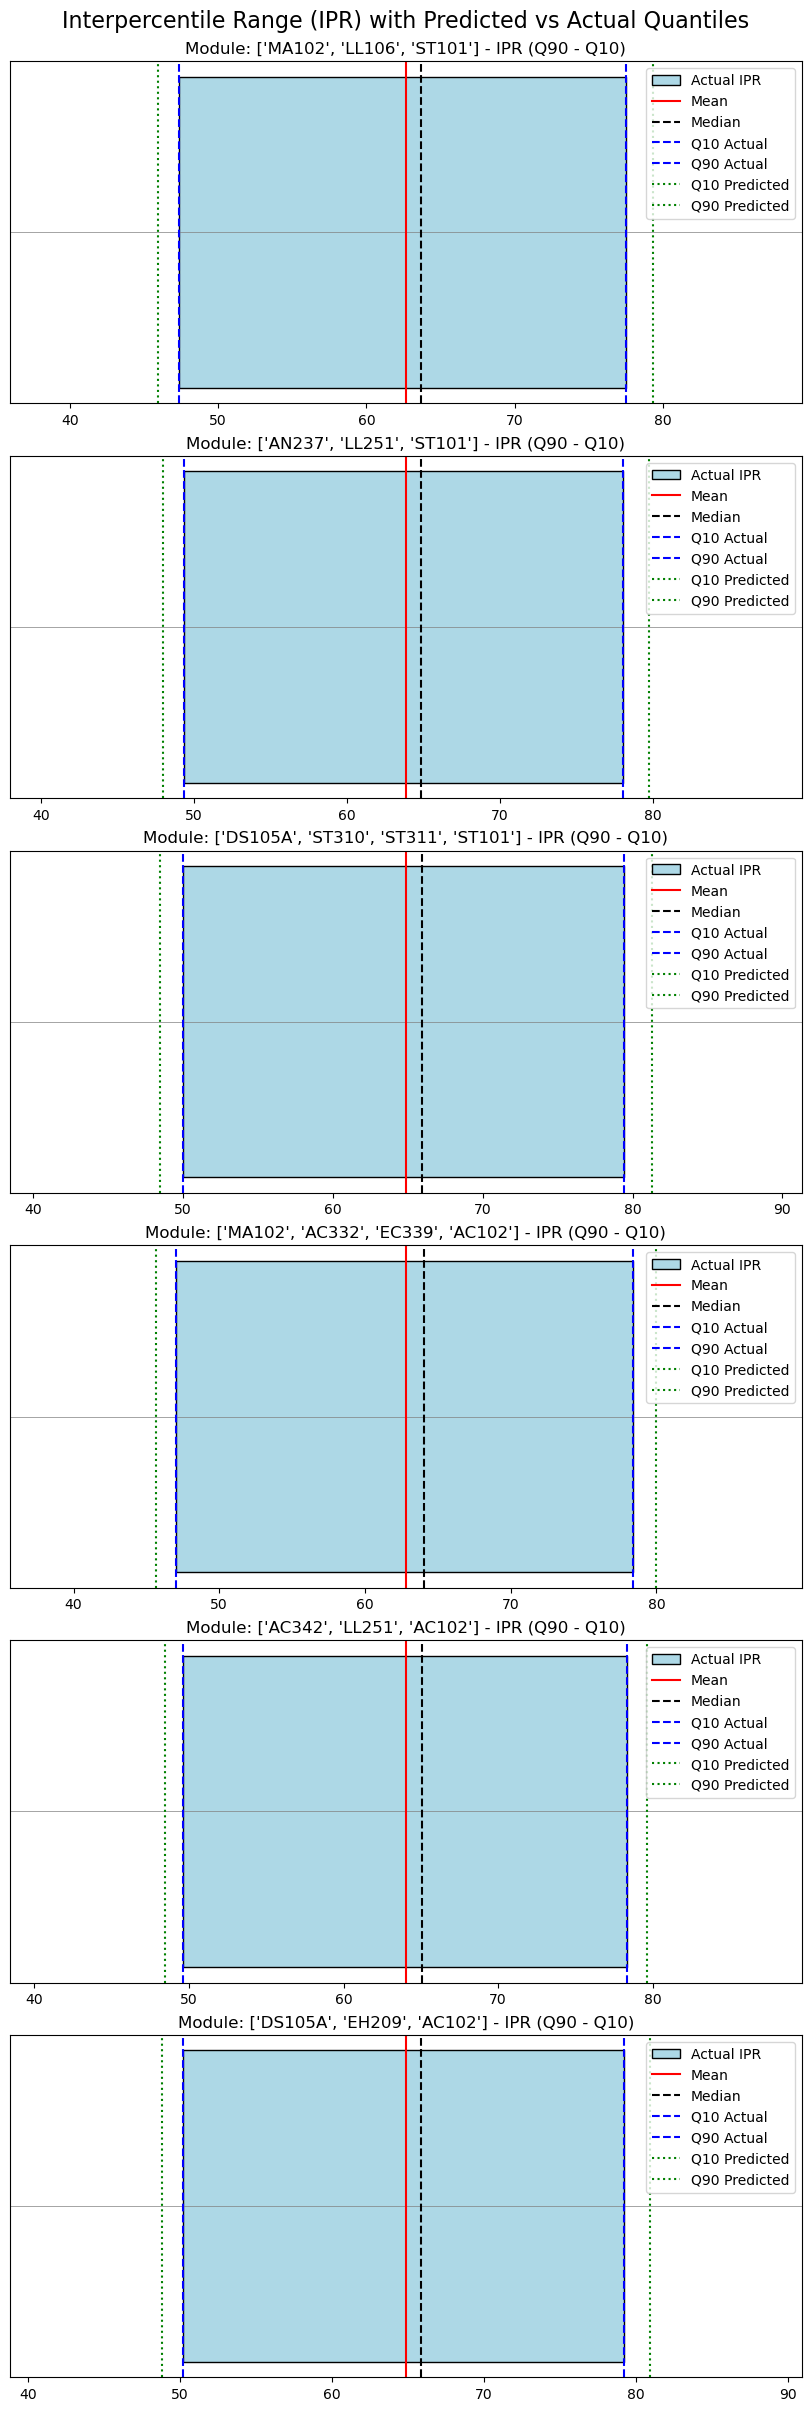

In [87]:
import matplotlib.pyplot as plt
n = len(manual_combinations_df)
fig, axes = plt.subplots(n, 1, figsize=(8, 4 * n), constrained_layout=True)
if n == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    row = manual_combinations_df.iloc[i]

    mean = row['Mean']
    sd = row['Pooled_SD']
    median = row['Median']
    q10_actual = row['Q10']
    q90_actual = row['Q90']
    module_name = row['Modules']

    # Predicted Q10 and Q90 using z = ±1.28
    q10_pred = mean - 1.28 * sd
    q90_pred = mean + 1.28 * sd

    # Plot actual IPR as a bar
    ax.broken_barh([(q10_actual, q90_actual - q10_actual)], (0.4, 0.2), facecolors='lightblue', edgecolor='black', label='Actual IPR')

    # Horizontal midline
    ax.axhline(0.5, color='gray', linestyle='-', linewidth=0.5)

    # Vertical lines
    ax.axvline(mean, color='red', linestyle='-', linewidth=1.5, label='Mean')
    ax.axvline(median, color='black', linestyle='--', label='Median')
    ax.axvline(q10_actual, color='blue', linestyle='--', label='Q10 Actual')
    ax.axvline(q90_actual, color='blue', linestyle='--', label='Q90 Actual')

    # Predicted Q10 and Q90
    ax.axvline(q10_pred, color='green', linestyle=':', label='Q10 Predicted')
    ax.axvline(q90_pred, color='green', linestyle=':', label='Q90 Predicted')

    # Labels & title
    ax.set_title(f'Module: {module_name} - IPR (Q90 - Q10)', fontsize=12)
    ax.set_yticks([])
    ax.set_xlim(min(q10_actual, q10_pred) - 10, max(q90_actual, q90_pred) + 10)
    ax.legend(loc='upper right')

plt.suptitle('Interpercentile Range (IPR) with Predicted vs Actual Quantiles', fontsize=16)
;

 * The data shows that finance makes its choice 1st but that doesn't lead to much of a different outcome. And the difference in the  average is very small between different difficulties. As the requirement to obtain a first is a degree score of 65.555 and none of the values are above this, it makes no difference to the final degree classification whether you try and design and easier or harder degree. 
 * More imporantly, assuming some form of normality amongst the data, there are clear limitations of this, but this allows us to conduct a hypthesis test, we can see that there is no statistical difference between any of the mean values. Assuming normalit lets us look at t tests, where at the 5% level the critical value is  2.365 for 7df(10 sample size minus restrictions from optional). As we dont know our degrees of freedom as we dont know the number of students taking each combination. We know that the T stat = difference/root of (variances/sample size) added together. In the most extreme case (AC Easy - AC hard), we have a T stat (assuming an n=10 {which is 1/6 of yearly finance cohort repersenting 1/2 choosing one path and then 1/3 choosing difficulty and as some of these courses are new there has only ever been one yearly cohort}) we have a T value of 0.35. This will be the largest for any of the data points and hence it is statistically unlikely that choosing your optional modules will change your overall degree average.
* Limitations also include the fact that none of the variances include the correlation between performance of students in different modules.
* An interesting obsevration is that the overall highest mean value design is very similar to what the department recommends on their homepage

In [88]:
econ_options = pd.read_csv("data/degrees/econm.csv")
econ_options.head()

Module  Year  Optional/Compulsory  Units
0  EC1P1     1                    0    0.5
1  EC1A1     1                    0    0.5
2  ST109     1                    0    0.5
3  EC1C1     1                    0    0.5
4  MA108     1                    1    0.5

In [89]:


initial_combinations_df3 = summarize_compulsory_modules(econ_options,)
initial_combinations_df3

Compulsory Modules  Total Compulsory Units  \
0  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2C1]                     5.0   

   Year 1 OO Units  Year 2 OO Units  Year 3 OO Units  \
0              1.0              1.0              1.0   

   Year 1 Non-OO Units Needed  Year 2 Non-OO Units Needed  \
0                         1.0                           0   

   Year 3 Non-OO Units Needed  
0                         3.0

In [90]:
year1_combos_df = generate_year1_optional_combinations(initial_combinations_df3, econ_options)
year1_combos_df

Compulsory Modules  Total Compulsory Units  \
0  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2C1]                     5.0   
0  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2C1]                     5.0   

   Year 1 OO Units  Year 2 OO Units  Year 3 OO Units  \
0              1.0              1.0              1.0   
0              1.0              1.0              1.0   

   Year 1 Non-OO Units Needed  Year 2 Non-OO Units Needed  \
0                           0                           0   
0                           0                           0   

   Year 3 Non-OO Units Needed  \
0                         3.0   
0                         3.0   

                                             Modules Optional Modules Added  \
0  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...                [MA100]   
0  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...         [MA108, EC1B1]   

   Total Units  
0          6.0  
0          6.0

From the dataset, I can observe that the easiest module pairing is DS105A withh AC102, the hardest is MA102 and ST101a and the median module is PH103. This is based on the mean for each module, and regardless of the optional module choice they made in 1st Year, this is a suitable pairing

In [91]:
import pandas as pd

difficulty_df = pd.DataFrame([
    {'Difficulty': 'Hard','Optional Modules Added': ['MA100'],'OO_added': ['MA102',"ST101A"]}, {'Difficulty': 'Medium',
        'Optional Modules Added': ['MA100'], 'OO_added': ['PH103']}, {'Difficulty': 'Easy', 'Optional Modules Added': ['MA100'],
        'OO_added': ['DS105A', 'AC102'] }, {'Difficulty': 'Hard', 'Optional Modules Added': ['MA108', 'EC1B1'],
        'OO_added': ['MA102',"ST101A"] }, {    'Difficulty': 'Medium',  'Optional Modules Added': ['MA108', 'EC1B1'],
        'OO_added': ['PH103'] }, { 'Difficulty': 'Easy', 'Optional Modules Added': ['MA108', 'EC1B1'], 'OO_added': ['DS105A', 'AC102'] }
])


def expand_with_difficulty_variants(year1_combos_df, difficulty_df):
    expanded_rows = []

    for _, row in year1_combos_df.iterrows():
        base_modules = row['Modules']
        base_optionals = row['Optional Modules Added']

        for _, diff_row in difficulty_df.iterrows():
            if sorted(diff_row['Optional Modules Added']) == sorted(base_optionals):
                new_row = row.copy()

                # Append OO modules to Optional Modules Added (instead of having OO_added as a separate column)
                new_optionals = base_optionals + diff_row['OO_added']
                new_modules = base_modules + diff_row['OO_added']

                # Create new expanded row
                expanded_rows.append({
                    'Modules': new_modules,
                    'Optional Modules Added': new_optionals,
                    'Difficulty': diff_row['Difficulty'],
                    # Preserve other original fields
                    **{col: row[col] for col in row.index if col not in ['Modules', 'Optional Modules Added']}
                })

    return pd.DataFrame(expanded_rows)


year_1incOO_df = expand_with_difficulty_variants(year1_combos_df, difficulty_df)


def update_total_units(year_1incOO_df, summary_df):
    # Create a dictionary from summary_df to map module codes to their units
    module_units_dict = summary_df.set_index('code')['units'].to_dict()

    # Function to calculate total units for a list of modules
    def calculate_total_units(modules_list):
        return sum(module_units_dict.get(module, 0) for module in modules_list)

    # Apply the calculate_total_units function to each row in year_1incOO_df
    year_1incOO_df['Total Units'] = year_1incOO_df['Modules'].apply(calculate_total_units)

    return year_1incOO_df

update_total_units(year_1incOO_df, summary_df)



Modules  \
0  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...   
1  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...   
2  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...   
3  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...   
4  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...   
5  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...   

          Optional Modules Added Difficulty  \
0         [MA100, MA102, ST101A]       Hard   
1                 [MA100, PH103]     Medium   
2         [MA100, DS105A, AC102]       Easy   
3  [MA108, EC1B1, MA102, ST101A]       Hard   
4          [MA108, EC1B1, PH103]     Medium   
5  [MA108, EC1B1, DS105A, AC102]       Easy   

                                  Compulsory Modules  Total Compulsory Units  \
0  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2C1]                     5.0   
1  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2C1]                     5.0   
2  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2C1]                     5.0   
3  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2C1]                     5.0   
4  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2C1]                     5.0   
5  [EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2C1]                     5.0   

   Year 1 OO Units  Year 2 OO Units  Year 3 OO Units  \
0              1.0              1.0              1.0   
1              1.0              1.0              1.0   
2              1.0              1.0              1.0   
3              1.0              1.0              1.0   
4              1.0              1.0              1.0   
5              1.0              1.0              1.0   

   Year 1 Non-OO Units Needed  Year 2 Non-OO Units Needed  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   
5                           0                           0   

   Year 3 Non-OO Units Needed  Total Units  
0                         3.0          7.0  
1                         3.0          7.0  
2                         3.0          7.0  
3                         3.0          7.0  
4                         3.0          7.0  
5                         3.0          7.0

From inspection of the course page, in 3rd year Econ students choose 3.0 units from an approved list and then they can do an OO, or anothee 1.0 units from the approved list. For simplicity I will choose 4.0 units from this fixed list in 3rd year, however as some of these Units have prerequisites based on the outside option. From Manual Inspection I know that these are the finance courses which dont have any data, therefore there is no point choosing the finance courses for hardest, median, or easiest as those courses are not the hardest or easiest.


In [92]:
import pandas as pd

def add_summary_and_prereqs(econ_options, summary_df, outside_options_marks):
    # Merge econ_options with summary_df based on matching 'Module' and 'code'
    merged_df = pd.merge(econ_options, summary_df, left_on='Module', right_on='code', how='left')

    # Merge econ_options with outside_options_marks to get prerequisites and exclusions
    merged_with_outside = pd.merge(merged_df, outside_options_marks[['code', 'parsed_prereqs', 'parsed_exclusions']],
                                   left_on='Module', right_on='code', how='left')


    # Drop the unnecessary 'code' column after merging, as we already have 'Module'
    if 'code' in merged_with_outside.columns:
        merged_with_outside = merged_with_outside.drop(columns=['code'])
    
    # Return the final merged DataFrame
    return merged_with_outside


merged_df_e = add_summary_and_prereqs(econ_options, summary_df,outside_options_marks)

merged_df_e3= merged_df_e[merged_df_e['Year'] == 3]
merged_df_e3 = merged_df_e3.sort_values(by='mean', ascending=False)
merged_df_e3 = merged_df_e3.dropna(subset=['mean'])
merged_df_e3 = merged_df_e3[~merged_df_e3['Module'].isin(['FM322', 'FM321'])]
merged_df_e3.head()

Module  Year  Optional/Compulsory  Units code_x       mean    q10  Median  \
26  EC336     3                    1    0.5  EC336  81.200000  71.50    82.5   
28  EC338     3                    1    0.5  EC338  75.300000  51.20    80.0   
24  EC334     3                    1    0.5  EC334  70.300000  59.80    69.0   
13  EC307     3                    1    1.0  EC307  69.420201  61.58    70.4   
36  PH311     3                    1    1.0  PH311  69.136341  61.96    69.4   

      q90  Pooled_SD  Total Takers  Years Counted  units code_y  \
26  89.50   8.300000           6.0            1.0    0.5  EC336   
28  91.00  18.600000          43.0            1.0    0.5  EC338   
24  80.20   8.200000          19.0            1.0    0.5  EC334   
13  78.60   7.888646         159.4            5.0    1.0  EC307   
36  74.68   7.903559          79.8            5.0    1.0  PH311   

                                       parsed_prereqs parsed_exclusions  
26                              [ST102, MA100, ST109]                []  
28                                     [EC201, EC202]                []  
24         [FM201, MA107, EC221, EC220, MA100, EC210]                []  
13  [ST109, MA107, EC221, ST102, EC220, EC202, EC2...                []  
36                                                 []                []

In [93]:
# print_sorted_by_mean(outside_options_marks,num=10)

* 2nd Year Outside Option:
  *  Hard MA212 for both trees, MA100/MA108 and MA102 is the prereq
  *  Median HY206 for both
  *  Easiest LN200 for both
  
* 3rd Year Econ Courses: Note we are not going to take any finance courses as they are all new, and hence will ignore FM322
  * To obtain this data we will work out the combinations of courses here that add up to 4.0 units, luckily we pass every course regarding prerequisites so that is not a hassle and therefore there isn't really a difference between the different paths we take

In [45]:
import pandas as pd
from itertools import combinations
import numpy as np

def find_mean_of_means_combinations(df, target_units=4.0, code_col='Module', mean_col='mean', unit_col='Units'):
    valid_combos = []

    # Loop through all possible course combinations
    for r in range(1, len(df) + 1):
        for combo in combinations(df.itertuples(index=False), r):
            total_units = sum(getattr(c, unit_col) for c in combo)
            if np.isclose(total_units, target_units):
                mean_scores = [getattr(c, mean_col) for c in combo]
                avg_mean = np.mean(mean_scores)
                combo_df = pd.DataFrame(combo)
                combo_df['mean_of_means'] = avg_mean
                combo_df['combo_codes'] = ", ".join(getattr(c, code_col) for c in combo)
                valid_combos.append((combo_df, avg_mean))

    if not valid_combos:
        return {"lowest": None, "median": None, "highest": None}

    # Sort combos by "mean of means"
    sorted_combos = sorted(valid_combos, key=lambda x: x[1])
    mid_index = len(sorted_combos) // 2

    return {
        "lowest": sorted_combos[0][0].reset_index(drop=True),
        "median": sorted_combos[mid_index][0].reset_index(drop=True),
        "highest": sorted_combos[-1][0].reset_index(drop=True)
    }

# Step 3: Run the function
result = find_mean_of_means_combinations(merged_df_e3, target_units=4.0)


#Step 4: Display the DataFrames
#print("🔻 Lowest Mean of Means Combo:")
#display(result['lowest'])

#print("🔘 Median Mean of Means Combo:")
#display(result['median'])

#print("🔺 Highest Mean of Means Combo:")
#display(result['highest'])

* Hard EC302,ec310,ec337,ec319,ec335,MA212
* Median ec338,ec313,ec321,ec311,ec339,HY206
* Easy Ec336,ec338,ec307,ph311,ec330,LN200



In [46]:
append_dict = {
    'Hard': ['EC302','EC310','EC337','EC319','EC335','MA212'],
    'Medium': ['EC338','EC313','EC321','EC311','EC339','HY206'],
    'Easy': ['EC336','EC338','EC307','PH311','EC330','LN200']
}
year_1incOO_df2 = year_1incOO_df.copy()
for difficulty, additions in append_dict.items():
    mask = year_1incOO_df2['Difficulty'] == difficulty
    
    # Only add new items not already present in the lists
    year_1incOO_df2.loc[mask, 'Modules'] = year_1incOO_df2.loc[mask, 'Modules'].apply(
        lambda x: x + [mod for mod in additions if mod not in x]
    )
    year_1incOO_df2.loc[mask, 'Optional Modules Added'] = year_1incOO_df2.loc[mask, 'Optional Modules Added'].apply(
        lambda x: x + [mod for mod in additions if mod not in x]
    )
update_total_units(year_1incOO_df2, summary_df)
print("Units Updated")

Units Updated


In [47]:
year_1incOO_df2[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = year_1incOO_df2['Modules'].apply(
    lambda x: pd.Series(
        calculate_statistics_for_modules(x, summary_df)
        if calculate_statistics_for_modules(x, summary_df) is not None
        else [np.nan, np.nan, np.nan, np.nan, np.nan],
        index=['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']
    )
)
year_1incOO_df2["degree"] = "Economics"
year_1incOO_df2[["Optional Modules Added","Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]]


Optional Modules Added Difficulty       Mean  \
0  [MA100, MA102, ST101A, EC302, EC310, EC337, EC...       Hard  61.230699   
1  [MA100, PH103, EC338, EC313, EC321, EC311, EC3...     Medium  64.422811   
2  [MA100, DS105A, AC102, EC336, EC338, EC307, PH...       Easy  67.349407   
3  [MA108, EC1B1, MA102, ST101A, EC302, EC310, EC...       Hard  61.439569   
4  [MA108, EC1B1, PH103, EC338, EC313, EC321, EC3...     Medium  64.631682   
5  [MA108, EC1B1, DS105A, AC102, EC336, EC338, EC...       Easy  67.558278   

      Median        Q10        Q90  Pooled_SD     degree  
0  62.239236  45.122639  76.860903  13.746595  Economics  
1  65.652778  49.861389  77.718611  12.484491  Economics  
2  68.792361  54.178472  79.444028  11.233336  Economics  
3  62.550347  45.526806  76.712292  13.471702  Economics  
4  65.963889  50.265556  77.570000  12.209598  Economics  
5  69.103472  54.582639  79.295417  10.958443  Economics

In [48]:
ir_options = pd.read_csv("data/degrees/irm.csv")
ir_options.head()


Module  Year  Optional/Compulsory  Units
0  IR100     1                    0    1.0
1  IR101     1                    0    1.0
2  HY113     1                    1    1.0
3  HY116     1                    1    1.0
4  EH101     1                    1    1.0

In [49]:
initial_combinations_dfir = summarize_compulsory_modules(ir_options,)


In [50]:
year1_combos_dfir = generate_year1_optional_combinations(initial_combinations_dfir, ir_options)
                                                              
                                                                                                                                                         

In [51]:
year1_combos_dfirf = year1_combos_dfir[year1_combos_dfir['Optional Modules Added'].isin([[ 'HY113', 'HY116' ], [ 'HY113', 'EH101' ],
[ 'HY113', 'GV101' ],[ 'HY113', 'PH103' ],[ 'HY113', 'SO100' ],[ 'HY116', 'EH101' ],[ 'HY116', 'GV101' ],[ 'HY113', 'PH103' ],
['HY113', 'SO10O' ]])]
   

In [52]:
merged_df_ir = add_summary_and_prereqs(ir_options, summary_df,outside_options_marks)

merged_df_ir3= merged_df_ir[merged_df_ir['Year'] == 3]
merged_df_ir3 = merged_df_ir3.sort_values(by='mean', ascending=False)
merged_df_ir3 = merged_df_ir3.dropna(subset=['mean'])
merged_df_ir3 = merged_df_ir3.dropna(subset=['mean'])
merged_df_ir3 = merged_df_ir3[~merged_df_ir3['Module'].isin(['LL342'])]

merged_df_ir2= merged_df_ir[merged_df_ir['Year'] == 2]
merged_df_ir2 = merged_df_ir2.sort_values(by='mean', ascending=False)
merged_df_ir2 = merged_df_ir2.dropna(subset=['mean'])

result_ir2 = find_mean_of_means_combinations(merged_df_ir2, target_units=4.0)
result_ir3 = find_mean_of_means_combinations(merged_df_ir3, target_units=3.0)
#print("🔻 Lowest Mean of Means Combo:")
#display(result_ir3['lowest'])

#print("🔘 Median Mean of Means Combo:")
#display(result_ir3['median'])

#print("🔺 Highest Mean of Means Combo:")
#display(result_ir3['highest'])
#print("🔻 Lowest Mean of Means Combo:")
#display(result_ir2['lowest'])

#print("🔘 Median Mean of Means Combo:")
#display(result_ir2['median'])

#print("🔺 Highest Mean of Means Combo:")
#display(result_ir2['highest'])

In [53]:
append_dict_ir3 = {
    'Hard': ['IR315','IR380','IR317','IR379','IR368'],
    'Medium': ['IR373','IR395','IR398','IR317','IR379'],
    'Easy': ['IR377' ,'IR373','IR391','IR323','IR398']
}

append_dict_ir2 = {
    'Hard': ['IR206','IR203','IR205','IR202'],
    'Medium': ['IR200','IR206','IR205','IR202'],
    'Easy': ['IR200','IR206','IR203','IR205']
}

year1_combos_dfirf2 = year1_combos_dfirf .copy()

year1_combos_dfirf2 = create_difficulty_subrows(year1_combos_dfirf2)

for difficulty, additions in append_dict_ir2.items():
    mask = year1_combos_dfirf2['Difficulty'] == difficulty
    
    # Only add new items not already present in the lists
    year1_combos_dfirf2.loc[mask, 'Modules'] = year1_combos_dfirf2.loc[mask, 'Modules'].apply(
        lambda x: x + [mod for mod in additions if mod not in x]
    )
    year1_combos_dfirf2.loc[mask, 'Optional Modules Added'] = year1_combos_dfirf2.loc[mask, 'Optional Modules Added'].apply(
        lambda x: x + [mod for mod in additions if mod not in x]
    )
for difficulty, additions in append_dict_ir3.items():
    mask = year1_combos_dfirf2['Difficulty'] == difficulty
    
    # Only add new items not already present in the lists
    year1_combos_dfirf2.loc[mask, 'Modules'] = year1_combos_dfirf2.loc[mask, 'Modules'].apply(
        lambda x: x + [mod for mod in additions if mod not in x]
    )
    year1_combos_dfirf2.loc[mask, 'Optional Modules Added'] = year1_combos_dfirf2.loc[mask, 'Optional Modules Added'].apply(
        lambda x: x + [mod for mod in additions if mod not in x]
    )
year1_combos_dfirf2 = update_total_units(year1_combos_dfirf2, summary_df)


In [54]:
year1_combos_dfirf2[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = year1_combos_dfirf2['Modules'].apply(
    lambda x: pd.Series(
        calculate_statistics_for_modules(x, summary_df)
        if calculate_statistics_for_modules(x, summary_df) is not None
        else [np.nan, np.nan, np.nan, np.nan, np.nan],
        index=['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']
    )
)
year1_combos_dfirf2["degree"] = "IR"
year1_combos_dfirf2[["Optional Modules Added","Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]]

Optional Modules Added Difficulty       Mean  \
0  [HY113, HY116, IR206, IR203, IR205, IR202, IR3...       Hard  64.868774   
0  [HY113, HY116, IR200, IR206, IR205, IR202, IR3...     Medium  65.561135   
0  [HY113, HY116, IR200, IR206, IR203, IR205, IR3...       Easy  66.030382   
0  [HY113, EH101, IR206, IR203, IR205, IR202, IR3...       Hard  64.952634   
0  [HY113, EH101, IR200, IR206, IR205, IR202, IR3...     Medium  65.644996   
0  [HY113, EH101, IR200, IR206, IR203, IR205, IR3...       Easy  66.114243   
0  [HY113, GV101, IR206, IR203, IR205, IR202, IR3...       Hard  64.842002   
0  [HY113, GV101, IR200, IR206, IR205, IR202, IR3...     Medium  65.534364   
0  [HY113, GV101, IR200, IR206, IR203, IR205, IR3...       Easy  66.003611   
0  [HY113, HY116, IR206, IR203, IR205, IR202, IR3...       Hard  64.868774   
0  [HY113, HY116, IR200, IR206, IR205, IR202, IR3...     Medium  65.561135   
0  [HY113, HY116, IR200, IR206, IR203, IR205, IR3...       Easy  66.030382   
0  [HY113, PH103, IR206, IR203, IR205, IR202, IR3...       Hard  65.015797   
0  [HY113, PH103, IR200, IR206, IR205, IR202, IR3...     Medium  65.708158   
0  [HY113, PH103, IR200, IR206, IR203, IR205, IR3...       Easy  66.177405   
0  [HY113, SO100, IR206, IR203, IR205, IR202, IR3...       Hard  64.904599   
0  [HY113, SO100, IR200, IR206, IR205, IR202, IR3...     Medium  65.596961   
0  [HY113, SO100, IR200, IR206, IR203, IR205, IR3...       Easy  66.066208   
0  [HY116, EH101, IR206, IR203, IR205, IR202, IR3...       Hard  64.863642   
0  [HY116, EH101, IR200, IR206, IR205, IR202, IR3...     Medium  65.556003   
0  [HY116, EH101, IR200, IR206, IR203, IR205, IR3...       Easy  66.025250   
0  [HY116, GV101, IR206, IR203, IR205, IR202, IR3...       Hard  64.753010   
0  [HY116, GV101, IR200, IR206, IR205, IR202, IR3...     Medium  65.445371   
0  [HY116, GV101, IR200, IR206, IR203, IR205, IR3...       Easy  65.914618   
0  [HY113, HY116, IR206, IR203, IR205, IR202, IR3...       Hard  64.868774   
0  [HY113, HY116, IR200, IR206, IR205, IR202, IR3...     Medium  65.561135   
0  [HY113, HY116, IR200, IR206, IR203, IR205, IR3...       Easy  66.030382   
0  [HY113, PH103, IR206, IR203, IR205, IR202, IR3...       Hard  65.015797   
0  [HY113, PH103, IR200, IR206, IR205, IR202, IR3...     Medium  65.708158   
0  [HY113, PH103, IR200, IR206, IR203, IR205, IR3...       Easy  66.177405   
0  [HY113, SO100, IR206, IR203, IR205, IR202, IR3...       Hard  64.904599   
0  [HY113, SO100, IR200, IR206, IR205, IR202, IR3...     Medium  65.596961   
0  [HY113, SO100, IR200, IR206, IR203, IR205, IR3...       Easy  66.066208   

      Median        Q10        Q90  Pooled_SD degree  
0  65.450000  57.547917  72.195417   7.186036     IR  
0  65.964583  58.052500  72.786667   6.907933     IR  
0  66.283333  58.689167  73.115833   6.516446     IR  
0  65.633333  57.641250  72.318750   7.209371     IR  
0  66.147917  58.145833  72.910000   6.931268     IR  
0  66.466667  58.782500  73.239167   6.539781     IR  
0  65.516667  57.869583  71.875417   7.239220     IR  
0  66.031250  58.374167  72.466667   6.961117     IR  
0  66.350000  59.010833  72.795833   6.569630     IR  
0  65.450000  57.547917  72.195417   7.186036     IR  
0  65.964583  58.052500  72.786667   6.907933     IR  
0  66.283333  58.689167  73.115833   6.516446     IR  
0  65.750000  57.912917  72.262083   7.581613     IR  
0  66.264583  58.417500  72.853333   7.303510     IR  
0  66.583333  59.054167  73.182500   6.912023     IR  
0  65.550000  57.797917  72.063750   7.144443     IR  
0  66.064583  58.302500  72.655000   6.866340     IR  
0  66.383333  58.939167  72.984167   6.474854     IR  
0  65.491667  57.474583  72.337083   7.243921     IR  
0  66.006250  57.979167  72.928333   6.965818     IR  
0  66.325000  58.615833  73.257500   6.574331     IR  
0  65.375000  57.702917  71.893750   7.273770     IR  
0  65.889583  58.207500  72.485000   6.995667     IR  
0  66.208333  58.844167  72.814167   6.604181     IR  
0 

Luckily IR is an easy course to analyse, as the options I am looking at do not have any prerequisites, so it was easy to analyse

So far we have analysed, our own degree (with the highest grad salary), economics (quite optional but across a degree with a very high grad salary), IR (not as high of a salary, but a very optional course), and have found that the difference between easy and hard has not been massive. We attribute this to the fact that Finance, is not very optional at all and hence the units which can be chosen to very easy take a small % of the course. Economics has a relatively large spread, but once again is not the most optional and the choices are made between a fixed list, meaning that the actual final difference between easy and hard is limited. IR also suffers from this problem as in 2nd year there is a choice of 4 courses out of a possible 5, with something similar in 3rd year. Therefore, we decided to finally analyse a course which has 2.0 units of outside option choice, across quite a range of different subjects. This was Politics and Economics.

In [55]:
pe_options = pd.read_csv("data/degrees/pem.csv")
pe_options.head()


Module  Year  Optional/Compulsory  Units
0  GV100     1                    0    1.0
1  GV101     1                    0    1.0
2  EC1A3     1                    0    0.5
3  EC1B3     1                    0    0.5
4  MA107     1                    0    0.5

In [56]:
initial_combinations_dfpe = summarize_compulsory_modules(pe_options,)

In [57]:
year1_combos_dfpe = generate_year1_optional_combinations(initial_combinations_dfpe, pe_options)
year1_combos_dfpe2= create_difficulty_subrows(year1_combos_dfpe) 


In [58]:
merged_df_pe = add_summary_and_prereqs(pe_options, summary_df,outside_options_marks)


from inspection of the course guides, all the optionals that studetns can pick from, they meet the prerequisites for.

In [59]:
merged_df_pe2= merged_df_pe[merged_df_pe['Year'] == 2]
merged_df_pe2 = merged_df_pe2.sort_values(by='mean', ascending=False)
merged_df_pe2 = merged_df_pe2.dropna(subset=['mean'])
merged_df_pe2 = merged_df_pe2[merged_df_pe2['Optional/Compulsory'] == 1.0]



merged_df_pe3GV =merged_df_pe[merged_df_pe['Year'] == 3]
merged_df_pe3GV = merged_df_pe3GV[merged_df_pe3GV['Optional/Compulsory'] == 1.0]
merged_df_pe3GV = merged_df_pe3GV.sort_values(by='mean', ascending=False)
merged_df_pe3GV = merged_df_pe3GV.dropna(subset=['mean'])
merged_df_pe3GV = merged_df_pe3GV[merged_df_pe3GV['Module'].str.startswith('GV')]



merged_df_pe3EC =merged_df_pe[merged_df_pe['Year'] == 3]
merged_df_pe3EC = merged_df_pe3EC[merged_df_pe3EC['Optional/Compulsory'] == 1.0]
merged_df_pe3EC = merged_df_pe3EC.sort_values(by='mean', ascending=False)
merged_df_pe3EC = merged_df_pe3EC.dropna(subset=['mean'])
merged_df_pe3EC = merged_df_pe3EC[merged_df_pe3EC['Module'].str.startswith('EC')]


In [60]:
result_pe2 = find_mean_of_means_combinations(merged_df_pe2, target_units=2.0)
result_pe3g = find_mean_of_means_combinations(merged_df_pe3GV, target_units= 1.0)
result_pe3e = find_mean_of_means_combinations(merged_df_pe3EC, target_units=1.0)
#print("🔻 Lowest Mean of Means Combo:")
#display(result_pe3g['lowest'])

#print("🔘 Median Mean of Means Combo:")
#display(result_pe3g['median'])

#print("🔺 Highest Mean of Means Combo:")
#display(result_pe3g['highest'])



Hard : GV248,GV262,GV325,GV313,EC339,EC335,
Medium: GV263,GV251,GV328,GV316,EC334,EC339
Easy: GV249,GV245,GV314,EC338,ECEC334

In [61]:
append_dict_pe2 = {
    'Hard': ['GV248','GV262','GV325','GV313','EC339','EC335','LL106','MA102','ST101A'],
    'Medium': ['GV263','GV251','GV328','GV316','EC334','EC339','LL221','LL205'],
    'Easy': ['GV249','GV245','GV314','EC338','EC334','DS105A','AC102','EH209']
}
year1_combos_dfpe3 =year1_combos_dfpe2.copy()
year1_combos_dfpe3['Modules'] = year1_combos_dfpe3.apply(
    lambda row: list(set(row['Modules'] + append_dict_pe2.get(row['Difficulty'], []))),
    axis=1
)

year1_combos_dfpe3['Optional Modules Added'] = year1_combos_dfpe3['Difficulty'].apply(
    lambda diff: append_dict_pe2.get(diff, [])
)
year1_combos_dfpe3 = update_total_units(year1_combos_dfpe3, summary_df)


In [62]:
#print_sorted_by_mean(outside_options_marks,num=30)


Hard: LL106, MA102, ST101A
Medium: LL221, LL205
Easy, DS105A, AC102, EH209

In [63]:
year1_combos_dfpe3[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = year1_combos_dfpe3['Modules'].apply(
    lambda x: pd.Series(
        calculate_statistics_for_modules(x, summary_df)
        if calculate_statistics_for_modules(x, summary_df) is not None
        else [np.nan, np.nan, np.nan, np.nan, np.nan],
        index=['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']
    )
)
year1_combos_dfpe3["degree"] = "Politics and Economics"
year1_combos_dfpe3[["Optional Modules Added","Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]]

Optional Modules Added Difficulty       Mean  \
0  [GV248, GV262, GV325, GV313, EC339, EC335, LL1...       Hard  60.956137   
0  [GV263, GV251, GV328, GV316, EC334, EC339, LL2...     Medium  63.477044   
0  [GV249, GV245, GV314, EC338, EC334, DS105A, AC...       Easy  65.502960   

      Median        Q10        Q90  Pooled_SD                  degree  
0  62.047569  48.735694  73.435764  12.162210  Politics and Economics  
0  64.319444  53.084444  73.975347   9.601774  Politics and Economics  
0  66.590972  52.948333  76.935833  11.026172  Politics and Economics

PBS, as it has the highest average for compulsory modules

In [102]:
pb_options = pd.read_csv("data/degrees/pbsm.csv")
pb_options.head()

Module  Year  Optional/Compulsory  Units
0  PB101     1                    0    1.0
1  PB100     1                    0    1.0
2  PB130     1                    0    1.0
3  AN100     1                    1    1.0
4  GC101     1                    1    1.0

In [133]:
initial_combinations_dfpb = summarize_compulsory_modules(pb_options)


In [132]:
year1_combos_dfpb = generate_year1_optional_combinations(initial_combinations_dfpb, pb_options)


In [131]:
year1_combos_dfpb2= create_difficulty_subrows(year1_combos_dfpb) 


In [130]:
merged_df_pb = add_summary_and_prereqs(pb_options, summary_df,outside_options_marks)
merged_df_pb2= merged_df_pb[merged_df_pb['Year'] == 3]
merged_df_pb2 = merged_df_pb2.sort_values(by='mean', ascending=False)
merged_df_pb2 = merged_df_pb2.dropna(subset=['mean'])
merged_df_pb2 = merged_df_pb2[merged_df_pb2['Optional/Compulsory'] == 1.0]
result_pb2 = find_mean_of_means_combinations(merged_df_pb2, target_units=0.5)
#print("🔻 Lowest Mean of Means Combo:")
#display(result_pb2['lowest'])

#print("🔘 Median Mean of Means Combo:")
#display(result_pb2['median'])

#print("🔺 Highest Mean of Means Combo:")
#display(result_pb2['highest'])

In [112]:
print_sorted_by_mean(outside_options_marks,num=30)

Lowest 30 mean rows:
       code       mean                                  prerequisites  \
258   MA222  48.790000                                      ['MA100']   
246   MA102  50.002740                    ['MA108', 'MA100', 'MA107']   
45    EC1B3  51.712965                                             []   
52    EC2C4  53.003552           ['ST102', 'MA107', 'ST107', 'MA100']   
247   MA103  53.980561                   ['MA108', 'MA100', 'MA160P']   
255   MA212  55.912429                                      ['MA100']   
66    EC335  56.400000           ['EC201', 'EC221', 'EC220', 'EC202']   
272   MG205  57.103034                             ['ST107', 'MA107']   
51    EC2C3  57.751934  ['MA107', 'ST102', 'MA108', 'MA100', 'ST107']   
49    EC2B3  58.287043                             ['MA100', 'MA107']   
7     AC332  58.551261                    ['AC100', 'AC200', 'AC102']   
285   MG307  58.644444                                      ['MG303']   
370   ST326  58.879808        

In [129]:
append_dict_pb3 = {
    'Hard': ['AC103','EC1B3','EC1A3'],
    'Medium': ['LL210','AN237'],
    'Easy': ['DS105A','EH215','AC102']
}

year1_combos_dfpb3 =year1_combos_dfpb2.copy()
year1_combos_dfpb3['Modules'] = year1_combos_dfpb3.apply(
    lambda row: list(set(row['Modules'] + append_dict_pb3.get(row['Difficulty'], []))),
    axis=1
)


year1_combos_dfpb3['Optional Modules Added'] = year1_combos_dfpb3['Difficulty'].apply(
    lambda diff: append_dict_pb3.get(diff, [])
)


In [135]:
year1_combos_dfpb3[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = year1_combos_dfpb3['Modules'].apply(
    lambda x: pd.Series(
        calculate_statistics_for_modules(x, summary_df)
        if calculate_statistics_for_modules(x, summary_df) is not None
        else [np.nan, np.nan, np.nan, np.nan, np.nan],
        index=['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']
    )
)
year1_combos_dfpb3["degree"] = "Psychological and Behavioural Science"
year1_combos_dfpb3[["Optional Modules Added","Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]]

Optional Modules Added Difficulty       Mean     Median        Q10  \
0   [AC103, EC1B3, EC1A3]       Hard  66.035814  66.634783  58.441884   
0          [LL210, AN237]     Medium  66.895464  67.427536  60.705072   
0  [DS105A, EH215, AC102]       Easy  67.780338  68.414493  60.667681   
0   [AC103, EC1B3, EC1A3]       Hard  66.321257  66.819048  58.598254   
0          [LL210, AN237]     Medium  67.262779  67.687302  61.076984   
0  [DS105A, EH215, AC102]       Easy  68.231927  68.768254  61.036032   
0   [AC103, EC1B3, EC1A3]       Hard  66.321257  66.819048  58.598254   
0          [LL210, AN237]     Medium  67.262779  67.687302  61.076984   
0  [DS105A, EH215, AC102]       Easy  68.231927  68.768254  61.036032   
0   [AC103, EC1B3, EC1A3]       Hard  66.289339  66.904348  58.647101   
0          [LL210, AN237]     Medium  67.148989  67.697101  60.910290   
0  [DS105A, EH215, AC102]       Easy  68.033863  68.684058  60.872899   
0   [AC103, EC1B3, EC1A3]       Hard  66.173307  66.695652  58.527101   
0          [LL210, AN237]     Medium  67.032957  67.488406  60.790290   
0  [DS105A, EH215, AC102]       Easy  67.917831  68.475362  60.752899   
0   [AC103, EC1B3, EC1A3]       Hard  66.192665  66.695652  58.520145   
0          [LL210, AN237]     Medium  67.052315  67.488406  60.783333   
0  [DS105A, EH215, AC102]       Easy  67.937189  68.475362  60.745942   

         Q90  Pooled_SD                                 degree  
0  74.242101   8.761865  Psychological and Behavioural Science  
0  73.758043   7.661563  Psychological and Behavioural Science  
0  75.438043   8.291042  Psychological and Behavioural Science  
0  74.550873   8.501468  Psychological and Behavioural Science  
0  74.020714   7.296376  Psychological and Behavioural Science  
0  75.860714   7.985806  Psychological and Behavioural Science  
0  74.550873   8.501468  Psychological and Behavioural Science  
0  74.020714   7.296376  Psychological and Behavioural Science  
0  75.860714   7.985806  Psychological and Behavioural Science  
0  74.506449   8.807468  Psychological and Behavioural Science  
0  74.022391   7.707166  Psychological and Behavioural Science  
0  75.702391   8.336645  Psychological and Behavioural Science  
0  74.299493   8.351291  Psychological and Behavioural Science  
0  73.815435   7.250990  Psychological and Behavioural Science  
0  75.495435   7.880469  Psychological and Behavioural Science  
0  74.283841   8.421173  Psychological and Behavioural Science  
0  73.799783   7.320871  Psychological and Behavioural Science  
0  75.479783   7.950350  Psychological and Behavioural Science

In [140]:
Final_Comparison = pd.concat([year1_combos_dfpb3,year1_combos_dfpe3,year1_combos_dfirf2,year_1incOO_df2,finance_combos], ignore_index=True)
Final_Comparison

Compulsory Modules  Total Compulsory Units  \
0   [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
1   [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
2   [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
3   [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
4   [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
5   [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
6   [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
7   [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
8   [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
9   [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
10  [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
11  [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
12  [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
13  [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
14  [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
15  [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
16  [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
17  [PB101, PB100, PB130, PB230, PB200, PB202, PB2...                     9.0   
18  [GV100, GV101, EC1A3, EC1B3, MA107, ST107, EC2...                     6.0   
19  [GV100, GV101, EC1A3, EC1B3, MA107, ST107, EC2...                     6.0   
20  [GV100, GV101, EC1A3, EC1B3, MA107, ST107, EC2...                     6.0   
21                              [IR100, IR101, LL342]                     3.0   
22                              [IR100, IR101, LL342]                     3.0   
23                              [IR100, IR101, LL342]                     3.0   
24                              [IR100, IR101, LL342]                     3.0   
25                              [IR100, IR101, LL342]                     3.0   
26                              [IR100, IR101, LL342]                     3.0   
27                              [IR100, IR101, LL342]                     3.0   
28                              [IR100, IR101, LL342]                     3.0   
29                              [IR100, IR101, LL342]                     3.0   
30                              [IR100, IR101, LL342]                     3.0   
31                              [IR100, IR101, LL342]                     3.0   
32                              [IR100, IR101, LL342]                     3.0   
33                              [IR100, IR101, LL342]                     3.0   
34                              [IR100, IR101, LL342]                     3.0   
35                              [IR100, IR101, LL342]                     3.0   
36                              [IR100, IR101, LL342]                     3.0   
37                              [IR100, IR101, LL342]                     3.0   
38                              [IR100, IR101, LL342]                     3.0   
39                              [IR100, IR101, LL342]                     3.0   
40                              [IR100, IR101, LL342]                     3.0   
41                              [IR100, IR101, LL342]                     3.0   
42                              [IR100, IR101, LL342]                     3.0   
43                              [IR100, IR101, LL342]                     3.0   
44                              [IR100, IR101, LL342]                     3.0   
45                              [IR100, IR101, LL342]                     3.0   
46                              [IR100, IR101, LL342]                     3.0   
47                              [IR100, IR101, LL342]                     3.0   
48                              [IR100, IR101, LL342]             

In [143]:
Final_Comparison = Final_Comparison.loc[[0, 5, 18, 20, 42, 50,54,59,63,65]] 
Final_Comparison[["Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]]

Difficulty       Mean     Median        Q10        Q90  Pooled_SD  \
0        Hard  66.035814  66.634783  58.441884  74.242101   8.761865   
5        Easy  68.231927  68.768254  61.036032  75.860714   7.985806   
18       Hard  60.956137  62.047569  48.735694  73.435764  12.162210   
20       Easy  65.502960  66.590972  52.948333  76.935833  11.026172   
42       Hard  64.753010  65.375000  57.702917  71.893750   7.273770   
50       Easy  66.177405  66.583333  59.054167  73.182500   6.912023   
54       Hard  61.230699  62.239236  45.122639  76.860903  13.746595   
59       Easy  67.558278  69.103472  54.582639  79.295417  10.958443   
63       Hard  62.659597  63.715530  47.388030  77.501515  13.051809   
65       Easy  64.856697  65.919697  50.004167  79.427652  12.831765   

                                   degree  
0   Psychological and Behavioural Science  
5   Psychological and Behavioural Science  
18                 Politics and Economics  
20                 Politics and Economics  
42                                     IR  
50                                     IR  
54                              Economics  
59                              Economics  
63                                Finance  
65                                Finance

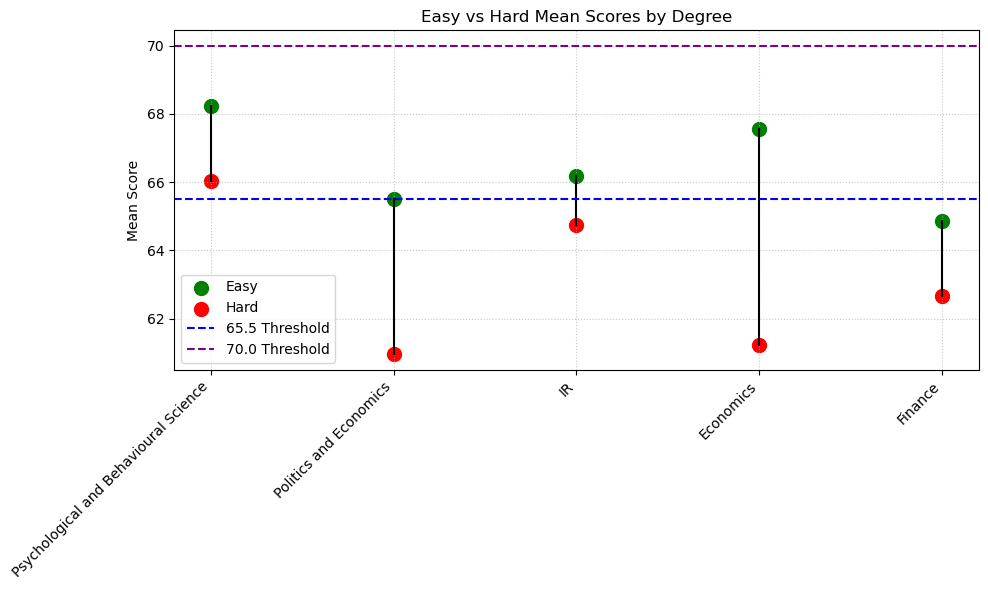

In [146]:
degrees =Final_Comparison["degree"].unique()
easy_means = Final_Comparison[Final_Comparison["Difficulty"] == 'Easy']["Mean"].values
hard_means =  Final_Comparison[Final_Comparison["Difficulty"] == 'Hard']["Mean"].values

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each degree's Easy and Hard as points + connect them with a line
for i, degree in enumerate(degrees):
    ax.plot([i, i], [hard_means[i], easy_means[i]], color='black')  # Line between hard and easy
    ax.scatter(i, easy_means[i], color='green', label='Easy' if i==0 else "", s=100)
    ax.scatter(i, hard_means[i], color='red', label='Hard' if i==0 else "", s=100)

# Add horizontal dashed lines
ax.axhline(65.5, color='blue', linestyle='--', label='65.5 Threshold')
ax.axhline(70.0, color='purple', linestyle='--', label='70.0 Threshold')

# Set x-axis labels
ax.set_xticks(range(len(degrees)))
ax.set_xticklabels(degrees, rotation=45, ha='right')

# Axis labels and title
ax.set_ylabel('Mean Score')
ax.set_title('Easy vs Hard Mean Scores by Degree')

# Show legend
ax.legend()

# Show grid for better readability
ax.grid(True, linestyle=':', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

In [154]:
pivot_df = Final_Comparison.pivot(index='degree', columns='Difficulty', values='Mean')

# Now calculate the range (Easy - Hard)
pivot_df['Range'] = pivot_df['Easy'] - pivot_df['Hard']

# Create the final dataframe with only degree and Range
range_df = pivot_df[['Range']].reset_index()

# Show it
range_df["Optionality"] = (7.0,2.5,11,3.5,3)
range_df

Difficulty                                 degree     Range  Optionality
0                                       Economics  6.327579          7.0
1                                         Finance  2.197100          2.5
2                                              IR  1.424396         11.0
3                          Politics and Economics  4.546823          3.5
4           Psychological and Behavioural Science  2.196113          3.0